## Gamma distribution

Paremeters $\alpha$ and $\beta$ are orthogonal if 

$$\operatorname{E}_X
\left[
 \frac{\partial \log f(X;\alpha,\beta)}{\partial\alpha \ \partial\beta}
 \right]=0$$

The probability density function of Gamma distribution parametrized by shape parameter $\kappa$ and scale parameter $\theta$ is
$$f(X=x;\kappa,\theta)=\frac{1}{\Gamma(\kappa) \theta^\kappa} x^{\kappa - 1} e^{-\frac{x}{\theta}}$$

Consider parametrization in terms of logarithm of geometric mean $\gamma=E[\log X]=\psi(\kappa)+\log \theta$ and log-scale $\tau=\log(\theta)$, where $\psi$ is the digamma function. Then the logarithm of density function parametrized by $\gamma$ and $\tau$ is

$$\log f(X=x;\gamma,\tau)=-\log{\Gamma(\omega(\gamma-\tau)) -\tau \omega(\gamma-\tau) + (\omega(\gamma-\tau)-1)\log x- x e^{-\tau}}$$

where we use $\omega$ to label the inverse digamma function. By $\omega'(x)$ $\omega''(x)$ and  we denote the first and second derivative of inverse digamma function with respect to $x$. Next, we compute the first derivative of the log-density with respect to $\gamma$:

$$\begin{align} \frac{\partial}{\partial\gamma}\log f(X;\gamma,\tau) &= -\psi(\omega(\gamma-\tau)) \omega'(\gamma-\tau)-\tau \omega'(\gamma-\tau) + \omega'(\gamma-\tau) \log x \\
&= -(\gamma-\tau) \omega'(\gamma-\tau)-\tau \omega'(\gamma-\tau) + \omega'(\gamma-\tau) \log x \\
&= (\log x - \gamma)\omega'(\gamma -\tau)\end{align}$$

Next we obtain derivative with respect to $\gamma$ and $\tau$:

$$\begin{align} \frac{\partial}{\partial\gamma \partial\tau}\log f(X;\gamma,\tau) &= \frac{\partial}{\partial\tau}\left[(\log x - \gamma)\omega'(\gamma -\tau)\right]\\
&= (\gamma-\log x)\omega''(\gamma-\tau)
\end{align}$$

Finally, compute the expectation
$$\begin{align} \operatorname{E}_X
\left[
 \frac{\partial \log f(X;\tau,\gamma)}{\partial\tau\ \partial\gamma}
 \right]&= \operatorname{E}\left[\omega''(\gamma-\tau)(\gamma-\log x)\right] \\
 &=\omega''(\gamma-\tau)(\gamma-\operatorname{E}[\log x])\\
 &=\omega''(\gamma-\tau)(\gamma-\gamma)\\
 &=0
\end{align}$$

Note that $\operatorname{E}[\log x]$ is the logarithm of geometric mean and hence $\operatorname{E}[\log x]=\gamma$

$$I_{\gamma \tau} = \omega'(\gamma-\tau) \begin{pmatrix}  
-1 & 0\\
0 & 2\tau \end{pmatrix} $$

$$I_{\zeta \kappa} = \begin{pmatrix}  
\kappa & 1\\
. & \psi'(\kappa) \end{pmatrix} $$
$\zeta=\log \theta$

$r_{\zeta \kappa}=1/\sqrt{\psi'(\kappa)\kappa}$

In [2]:
%pylab inline
from scipy.special import polygamma as pg

Populating the interactive namespace from numpy and matplotlib


In [11]:
s=2.1;1/np.sqrt(pg(1,s)*s)

0.8858264577731306

<ipython-input-10-b2855a97fa6d>:2: RuntimeWarning: invalid value encountered in multiply
  r=1/np.sqrt(pg(1,s)*s)


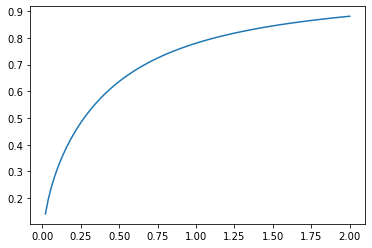

In [10]:
s=np.linspace(0,2,101)
r=1/np.sqrt(pg(1,s)*s)
plt.plot(s,r)

In [2]:
# stan implementation
import pystan
invgammafun='''functions{
    vector invdigamma(vector x){
        vector[num_elements(x)] y; vector[num_elements(x)] L;
        for (i in 1:num_elements(x)){
            if (x[i]==digamma(1)){ 
                y[i]=1;
            }else{ if (x[i]>=-2.22){
                y[i]=(exp(x[i])+0.5);
            }else{
                y[i]=1/(x[i]-digamma(1));
        }}}
        L=digamma(y)-x;
        while (min(L)>10^-12){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;
        }
        return y;}
    real invdigammaR(real x){
        real y; real L;
        if (x==digamma(1)){ 
            y=1;
        }else{ if (x>=-2.22){
            y=(exp(x)+0.5);
        }else{
            y=1/(x-digamma(1));
        }}
        L=digamma(y)-x;
        while (L>10^-12){
            y=y-L ./trigamma(y);
            L=digamma(y)-x;
        }
        return y;
    }} '''

model = """
data {
    int<lower=0> N; //nr subjects
    real g;
    real t;
}generated quantities{
    real<lower=0> y[N];
    for (n in 1:N)
        y[n]=gamma_rng(invdigammaR(g-t),exp(t));
}
"""
smGammaGen = pystan.StanModel(model_code=invgammafun+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_824d2ff1a315656690fe78fe32e606bf NOW.


In [16]:
N=100
fit=smGammaGen.sampling(data={'N':N,'g':5,'t':1},
    chains=4,n_jobs=4,seed=1,thin=1,iter=30,warmup=0,algorithm="Fixed_param")
w=fit.extract()
y=w['y'][0,:]
print(y.shape)

(100,)


In [9]:
model = """
data {
    int<lower=0> N; //nr subjects
    real<lower=0> y[N];
}parameters{
    real g;
    real t;
}model{
    for (n in 1:N)
        y[n]~gamma(invdigammaR(g-t),exp(t));
}
"""
smGamma = pystan.StanModel(model_code=invgammafun+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a2c12b646ca47fdd015655d17b12adc8 NOW.


In [17]:

fit=smGamma.sampling(data={'N':N,'y':y},
    chains=4,n_jobs=4,seed=1,thin=1,iter=1000,warmup=500)
print(fit)

Inference for Stan model: anon_model_a2c12b646ca47fdd015655d17b12adc8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
g      4.74    0.02   0.29    4.1   4.56   4.75   4.92   5.29    311   1.02
t      0.87  8.1e-3   0.14   0.55   0.78   0.88   0.96   1.15    314   1.02
lp__ -248.0    0.05   1.04 -250.7 -248.4 -247.7 -247.3 -247.0    442    1.0

Samples were drawn using NUTS at Tue Jan 21 14:48:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Hierarchical parameter recovery

In [29]:
model = """
data {
    int<lower=0> N; //nr subjects
    int<lower=0> M;
    real gm;
    real gs;
    real t;
}generated quantities{
    real g[N];
    real<lower=0> y[N,M];
    for (n in 1:N){
        g[n]=normal_rng(gm,gs);
        for (m in 1:M){
            y[n,m]=gamma_rng(invdigammaR(g[n]-t),exp(t));
}}}
"""
smGammaGen = pystan.StanModel(model_code=invgammafun+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f1c4cd5a7a2dd5bfc3c53aaa88ff7a5 NOW.


In [71]:
N=10;M=20
fit=smGammaGen.sampling(data={'N':N,'M':M,'gm':5,'gs':2,'t':1},
    chains=4,n_jobs=4,seed=1,thin=1,iter=30,warmup=0,algorithm="Fixed_param")
w=fit.extract()
y=w['y'][0,:,:]
print(y.shape)

(10, 20)


In [69]:
model = """
data {
    int<lower=0> N; //nr subjects
    int<lower=0> M;
    real<lower=0> y[N,M];
}parameters{
    real g[N];
    real gm;
    real<lower=0> gs;
    real t;
}model{
    for (n in 1:N){
        g[n]~normal(gm,gs);
        for (m in 1:M){
            y[n,m]~gamma(invdigammaR(g[n]-t),exp(t));
}}}
"""
smGamma = pystan.StanModel(model_code=invgammafun+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6a8758085290b91fe0fd36fc35263d5 NOW.


In [ ]:
fit=smGamma.sampling(data={'N':N,'M':M,'y':y},
    chains=4,n_jobs=4,seed=2,thin=1,iter=1000,warmup=500)
print(fit)

Populating the interactive namespace from numpy and matplotlib


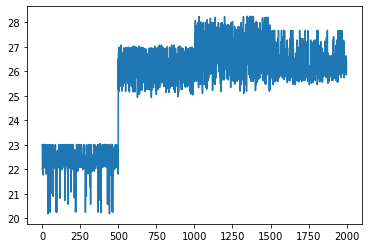

In [55]:
%pylab inline
plt.plot(w['gm'])

## Weibull distribution
$$f(x)=\frac{\alpha}{x }\left(\frac{x}{\theta}\right)^{\alpha}e^{-\left(\frac{x}{\theta} \right)^\alpha}$$

$$I_{\theta \alpha} = \begin{pmatrix}  
\frac{\alpha^2}{\theta^2} & -\frac{\psi(2)}{\theta}\\
. & \frac{1}{\alpha^2}\left(\psi'(2)+\psi(2)^2+1\right)\end{pmatrix} $$

$E[\log X]= \log \theta + \psi(1)/\alpha$

$E[X^s]=\theta^s \Gamma(1+s/\alpha)$

$E[X^\alpha]=\theta^\alpha $

$$E[X^\alpha \log X ]=\theta^\alpha (\log \theta + \psi(2)/\alpha)= \theta^\alpha (\log \theta + \psi(1)/\alpha+1/\alpha)$$

$$E[\log^2 X]= \log^2 \theta + 2 \log \theta \psi(1)/\alpha+(\psi'(1)+\psi(1)^2)/\alpha^2$$

$$E[X^\alpha \log^2 X]= \theta^\alpha  (\log^2 \theta + 2 \log \theta \psi(2)/\alpha+(\psi'(2)+\psi(2)^2)/\alpha^2)$$

$$E[X^{2\alpha} \log^2 X]= \theta^{2\alpha} 2 (\log^2 \theta + 2 \log \theta \psi(3)/\alpha+(\psi'(3)+\psi(3)^2)/\alpha^2)$$

$\mathrm{Var}[\log X]=\psi'(1)/\alpha^2$

$E[(X/\theta)^\alpha]=1$

$\mathrm{Var}[(X/\theta)^\alpha]=1$

$E[\log (X/\theta^\alpha)]= \psi(1)$

$E[\log^2 (X/\theta^\alpha)]= \psi'(1)+\psi(1)^2$

$E[(X/\theta)^\alpha \log (X/\theta)^\alpha ]= \psi(2)= 2\psi(1)+1$

$E[(X/\theta)^\alpha \log^2(X/\theta)^\alpha ]= \psi'(2)+\psi(2)^2$

$$\mathrm{Cov}(\gamma,\phi)=J_{12}J_{11}\frac{\alpha^2}{\theta^2}+J_{21}J_{22}\frac{1}{\alpha^2}\left(\psi'(2)+\psi(2)^2+1\right)-\frac{\psi(2)}{\theta}(J_{12}J_{11}+J_{21}J_{22}+J_{21}J_{12}+J_{11}J_{22})$$

$\theta=e^\phi$

$J_{11}=\frac{\partial \theta}{\partial \phi}=e^\phi=\theta$

$J_{12}=\frac{\partial \theta}{\partial \gamma}=0$

$$\mathrm{Cov}(\gamma,\phi)=J_{21}J_{22}\frac{1}{\alpha^2}\left(\psi'(2)+\psi(2)^2+1\right)-\frac{\psi(2)}{J_{11}}(J_{21}J_{22}+J_{11}J_{22})$$


$$\mathrm{Cov}(\gamma,\phi)=J_{22}\left(J_{21}\frac{1}{\alpha^2}\left(\psi'(2)+\psi(2)^2+1\right)-\psi(2)(J_{21}/J_{11}+1)\right)\\
= J_{21}J_{22}\frac{\psi(2)}{\alpha^2}\left( 
\frac{\psi'(2)+\psi(2)^2+1}{\psi(2)}-\alpha^2\left(\frac{\partial \phi}{\partial \alpha}+e^{-\phi}\right)\right)\\
= J_{21}J_{22}\psi(2)\left( 
\frac{\psi'(2)+\psi(2)^2+1}{\alpha^2\psi(2)}-e^{-\phi}-\frac{\partial \phi}{\partial \alpha}\right)
$$

$\gamma=-\phi- \frac{\psi'(2)+\psi(2)^2+1}{\alpha \psi(2)}$

$\frac{\partial \gamma}{\partial \alpha}= -\frac{\psi'(2)+\psi(2)^2+1}{\alpha^2 \psi(2)}$

$\alpha=-\frac{\psi'(2)+\psi(2)^2+1}{(\gamma+\phi) \psi(2)}$

$\frac{\partial \alpha}{\partial \phi}= \frac{\psi'(2)+\psi(2)^2+1}{(\gamma+\phi)^2 \psi(2)}$

$$\mathrm{Cov}(\gamma,\phi)= J_{21}J_{22}\psi(2)\left( 
\frac{(\gamma+\phi)^2 \psi(2)}{\psi'(2)+\psi(2)^2+1}-e^{-\phi}- \frac{(\gamma+\phi)^2 \psi(2)}{\psi'(2)+\psi(2)^2+1} \right)
$$

$c \mathrm{Ei}(\frac{c}{\alpha})-e^\frac{c}{\alpha}(e^{-\phi}+\alpha)=k$

$$I_{\zeta \alpha} = \begin{pmatrix}  
\alpha^2 & - \psi(2)\\
. & \frac{1}{\alpha^2}\left(\psi'(2)+\psi(2)^2+1\right)\end{pmatrix} $$
$\zeta=\log \theta$

$r_{\zeta \alpha}=\psi(2)/\sqrt{\psi'(1)+\psi(2)^2}=0.31$

In [7]:
import pystan
model = """
data {
    int<lower=0> N; //nr subjects
    vector<lower=0>[N] yLT;
}parameters {
    real bI;
    real aI;
}model {
  yLT~weibull(exp(aI),exp(bI));
}
"""
smWeibull = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9faf70dd96134384ec9388c0e4025e6a NOW.


In [47]:
from scipy import stats
x=np.linspace(0,10,101)[1:]
#plt.plot(x,gamma.pdf(x,3,0,2))
temp={'yLT':stats.weibull_min.rvs(np.exp(10),0,np.exp(-100),size=100),'N':100}
fit=smWeibull.sampling(data=temp,chains=6,n_jobs=6,
        seed=1,thin=2,iter=51000,warmup=1000)
print(fit)
w=fit.extract()
a=w['aI']
bw=w['bI']

Inference for Stan model: anon_model_9faf70dd96134384ec9388c0e4025e6a.
6 chains, each with iter=51000; warmup=1000; thin=2; 
post-warmup draws per chain=25000, total post-warmup draws=150000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bI   -100.0  1.6e-8 5.3e-6 -100.0 -100.0 -100.0 -100.0 -100.0 111975    nan
aI      9.9  4.5e-4   0.08   9.74   9.85    9.9   9.96  10.06  31613    1.0
lp__  1.1e4  4.5e-3   1.01  1.1e4  1.1e4  1.1e4  1.1e4  1.1e4  49932    1.0

Samples were drawn using NUTS at Tue Mar 20 11:25:45 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


0.00056276100313981258

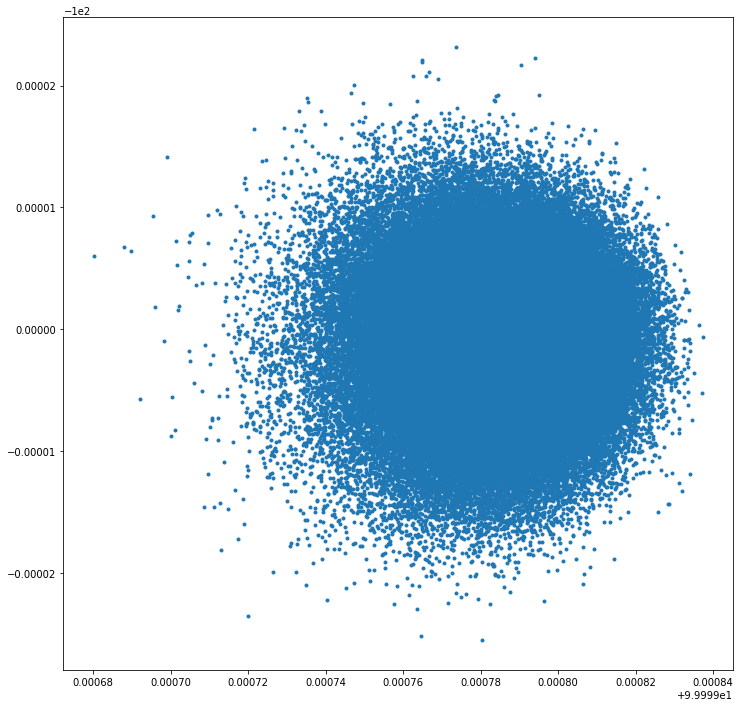

In [48]:
from scipy.special import gamma, digamma,polygamma,expi
plt.figure(figsize=(12,12))
g=a+digamma(1)/np.exp(bw)
m=np.exp(a)*gamma(1+1/np.exp(bw))
eq=np.log(np.power(np.exp(a),np.exp(bw))*gamma(2))
lam=np.log(np.power(np.exp(a),np.exp(bw)))
q2=bw
aa=np.exp(a)
q1= -(polygamma(1,2)+polygamma(0,2)**2+1)/polygamma(0,2)/aa-q2#np.exp(a-q2)
c=(polygamma(1,2)+polygamma(0,2)**2+1)/polygamma(0,2)
#q1=np.log(-c*expi(c/aa)+np.exp(c/aa)*(np.exp(-q2)+aa))
#q2=g
#k=np.exp(a)
#l=np.exp(b)
#q1=np.log(np.square(k)*digamma(2)+digamma(1))/(2*digamma(2))-g/(polygamma(1,1)+1)

plt.plot(q1,q2,'.')
np.corrcoef(q1,q2)[0,1]

# Information matrix generalized gamma

$$f(x)=\frac{\alpha}{x \Gamma(\kappa)}\left(\frac{x}{\theta}\right)^{\alpha \kappa}e^{-\left(\frac{x}{\theta} \right)^\alpha}$$

$$I_{\kappa \theta \alpha} = \begin{pmatrix} \psi'(\kappa) & -\frac{\alpha}{\theta} & \frac{\psi(\kappa)}{\alpha} \\
. & \frac{\kappa \alpha^2}{\theta^2} & \frac{\kappa}{\theta}\psi(\kappa+1)\\
. & . & \frac{\kappa}{\alpha^2}\left(\psi'(\kappa+1)+\psi(\kappa+1)^2+\frac{1}{\kappa}\right)\end{pmatrix} $$

$\kappa (\psi'(\kappa+1)+\psi(\kappa+1)^2+\frac{1}{k})= \kappa \psi'(\kappa)+\kappa \psi(\kappa)^2 + 2\psi(\kappa) +1$

$E[\log X]= \log \theta + \psi(\kappa)/\alpha$

$E[X^s]=\theta^s \Gamma(\kappa+s/\alpha)/\Gamma(\kappa)$

$E[X^q]=\theta^q \kappa$

$$E[X^q \log X ]=\theta^\alpha \kappa (\log \theta + \psi(\kappa+1)/\alpha)= \theta^\alpha (\kappa \log \theta + \kappa \psi(\kappa)/\alpha+1/\alpha)$$

$$E[\log^2 X]= \log^2 \theta + 2 \log \theta \psi(\kappa)/\alpha+(\psi'(\kappa)+\psi(\kappa)^2)/\alpha^2$$

$$E[X^q \log^2 X]= \theta^q \kappa (\log^2 \theta + 2 \log \theta \psi(\kappa+1)/\alpha+(\psi'(\kappa+1)+\psi(\kappa+1)^2)/\alpha^2)$$

$$E[X^{2q} \log^2 X]= \theta^{2q} (\kappa+1) (\log^2 \theta + 2 \log \theta \psi(\kappa+2)/\alpha+(\psi'(\kappa+2)+\psi(\kappa+2)^2)/\alpha^2)$$

# new

$\mathrm{Var}[\log X]=\psi'(\kappa)/\alpha^2$

$E[(X/\theta)^q]=\kappa$

$\mathrm{Var}[(X/\theta)^q]=\kappa$

$E[\log (X/\theta^q)]= \psi(\kappa)$

$E[\log^2 (X/\theta^q)]= \psi'(\kappa)+\psi(\kappa)^2$

$E[(X/\theta)^q \log (X/\theta)^q ]= \kappa \psi(\kappa+1)= \kappa \psi(\kappa)+1$

$E[(X/\theta)^q \log^2(X/\theta)^q ]= \kappa (\psi'(\kappa+1)+\psi(\kappa+1)^2)$

In [57]:
import pystan
ggcode='''functions{
//' Naive implementation of the generalized Gamma density.
//' @param x Value to evaluate density at.
//' @param alpha Shape parameter.
//' @param beta Scale parameter.
//' @param nu Tail parameter.
real gengamma_pdf(real x, real k, real b, real q) {
  real d;
  d = q/(b*tgamma(k))*(x/b)^(k*q-1) * exp(-(x/b)^q);
  return d;
}


real gengamma_lpdf(real x, real k, real b, real q) {
  real d;
  d = log(q) - log(b) - lgamma(k) +
    (k*q-1)*(log(x) - log(b)) - (x/b)^q;
  return d;
}


real generalized_gamma_cdf(real x, real k, real b, real q) {
  real d;
  d = gamma_p(k, (x/b)^q);
  return d;
}

real generalized_gamma_lcdf(real x, real k, real b, real q) {
  real d;
  d = log(generalized_gamma_cdf(x, k, b, q));
  return d;
}}'''

model = """
data {
    int<lower=0> N; //nr subjects
    vector<lower=0>[N] yLT;
}parameters {
    real k;
    real b;
    real q;
}model {
    for (n in 1:N)
        yLT[n]~gengamma(exp(k),exp(b),exp(q));
}
"""
smGengamma = pystan.StanModel(model_code=ggcode+model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dcdcb9f5b11fe563daed3fd8fb0103f8 NOW.


Inference for Stan model: anon_model_dcdcb9f5b11fe563daed3fd8fb0103f8.
6 chains, each with iter=5000; warmup=500; thin=10; 
post-warmup draws per chain=450, total post-warmup draws=2700.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
k      2.51    0.04   1.15    0.5   1.61   2.46   3.36   4.73    757   1.02
b     -3.64    0.18   3.28  -12.8  -4.84  -2.47  -1.31  -0.57    317   1.03
q      0.19    0.02   0.59  -0.96  -0.25   0.22   0.65   1.23    766   1.02
lp__  52.13    0.02   1.06  49.41  51.71  52.43  52.87  53.29   2489    1.0

Samples were drawn using NUTS at Wed Jan 22 14:45:54 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
11.691243192544015 0.08435327912949814 1.2431038670713754


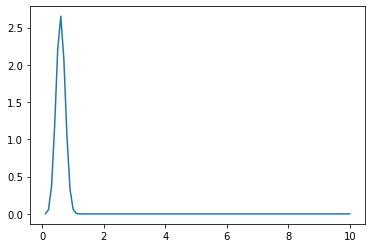

In [64]:
from scipy import stats
x=np.linspace(0,10,101)[1:]
#k,q,0,b
k=2;b=0.5;q=3;
plt.plot(x,stats.gengamma.pdf(x,k,q,0,b))
temp={'yLT':stats.gengamma.rvs(k,q,0,b,size=100),'N':100}

fit=smGengamma.sampling(data=temp,chains=6,n_jobs=6,
        seed=1,thin=10,iter=5000,warmup=500)
print(fit)
w=fit.extract()
k=np.exp(w['k'])
b=np.exp(w['b'])
q=np.exp(w['q'])
print(np.median(k),np.median(b),np.median(q))

(-50, 50)

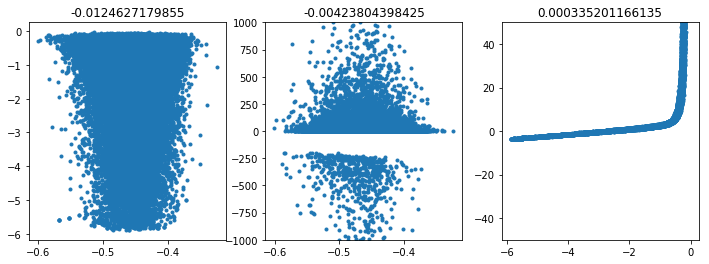

In [30]:
from scipy.special import gamma, digamma,polygamma
plt.figure(figsize=(12,4))
g=np.log(b)+digamma(k)/q
c=(polygamma(1,k+1)+polygamma(0,k+1)**2+1/k)*q/polygamma(0,k+1)+np.log(b)
q1=g
q2=np.log(b)
q3=c
#*np.exp(-a)+q2
plt.subplot(1,3,1)
plt.plot(q1,q2,'.')
plt.title(np.corrcoef(q1,q2)[0,1])
plt.subplot(1,3,2)
plt.plot(q1,q3,'.')
plt.title(np.corrcoef(q1,q3)[0,1])
plt.ylim([-1000,1000])
plt.subplot(1,3,3)
plt.plot(q2,q3,'.')
plt.title(np.corrcoef(q2,q3)[0,1]);
plt.ylim([-50,50])

# Beta distribution

Parameters $\alpha$ and $\beta$ are orthogonal if 

$$\operatorname{E}_X
\left[
 \frac{\partial \log f(X;\alpha,\beta)}{\partial\alpha \ \partial\beta}
 \right]=0$$

The probability density function of Beta distribution parametrized by shape parameters $\alpha$ and $\beta$ is
$$f(X=x;\alpha,\beta)=\frac{ x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}$$

Consider parametrization in terms of logarithm of geometric mean $E[\log X]=\gamma=\psi(\alpha)-\psi(\alpha+\beta)$ and the logarithm of geometric mean of $1-X$: $E[\log (1-X)]=\phi=\psi(\beta)-\psi(\alpha+\beta)$ 

Then the fisher information matrix of the distribution parametrized by shape parameters is

$$I_{\alpha,\beta}=\begin{pmatrix}\psi'(\alpha)-\psi'(\alpha+\beta) & -\psi'(\alpha+\beta)\\
-\psi'(\alpha+\beta) & \psi'(\beta)-\psi'(\alpha+\beta)
\end{pmatrix}$$

Fisher information matrix when parametrized by $\gamma$ and $\phi$ is

$$I_{\gamma,\phi}=J^\mathrm{T} I_{\alpha,\beta} J$$

Where $J$ is the Jacobian matrix defined as

$$J=\begin{pmatrix}\frac{\partial \alpha}{\partial \gamma} & \frac{\partial \alpha}{\partial \phi}\\
\frac{\partial \beta}{\partial \gamma} & \frac{\partial \beta}{\partial \phi}
\end{pmatrix}$$

Note that $I_{\alpha,\beta}$ can be written as:

$$I_{\alpha,\beta}=\begin{pmatrix}\frac{\partial \gamma}{\partial \alpha} & \frac{\partial \phi}{\partial \alpha} \\ \frac{\partial \gamma}{\partial \beta}  & \frac{\partial \phi}{\partial \beta}
\end{pmatrix}$$

$$\mathrm{Cov}(\gamma,\phi)=J_{12}J_{11}\psi'(\alpha)+J_{21}J_{22}\psi'(\beta)-\psi'(\alpha+\beta)(J_{12}J_{11}+J_{21}J_{22}+J_{21}J_{12}+J_{11}J_{22})$$

$\gamma=\psi(\alpha)-\psi(\alpha+\beta)$

$\phi=\psi(\beta)-\psi(\alpha+\beta)$

$\gamma-\phi=\psi(\alpha)-\psi(\beta)$

$\alpha=\omega(\phi-\psi(\beta))-\beta$

$\beta=\omega(\gamma-\psi(\alpha))-\alpha$

$$\gamma=\frac{\partial \log \mathrm{B}(\alpha,\beta)}{\partial \alpha}=\frac{\partial \log \Gamma(\alpha)}{\partial \alpha}-\frac{\partial \log \Gamma(\alpha+\beta)}{\partial \alpha}$$

$$\phi=\frac{\partial \log \mathrm{B}(\alpha,\beta)}{\partial \beta}=\frac{\partial \log \Gamma(\beta)}{\partial \beta}-\frac{\partial \log \Gamma(\alpha+\beta)}{\partial \beta}$$

$\psi'(\alpha)=\psi'(\alpha+\beta)\frac{\partial \beta}{\partial \alpha}  -\frac{1}{J_{11}}$

$\psi'(\beta)=\psi'(\alpha+\beta)\frac{\partial \alpha}{\partial \beta}  -\frac{1}{J_{22}}$

$I_{\alpha,\beta}=\begin{pmatrix}A+C & C \\ C & B+C
\end{pmatrix}$

$J^{-1}=\begin{pmatrix}A+C & C \\ C & B+C \end{pmatrix}$

$I_{\gamma,\phi}=J^\mathrm{T} I_{\alpha,\beta} J= J^\mathrm{T} J^{-1} J=J$

$$J=\frac{1}{AB+BC+AC}\begin{pmatrix}B+C & -C \\ -C & A+C \end{pmatrix}
= \begin{pmatrix}\frac{1}{A+\frac{BC}{B+C}} & -\frac{1}{A+B+\frac{AB}{C}} \\ -\frac{1}{A+B+\frac{AB}{C}} & \frac{1}{B+\frac{AC}{A+C}} \end{pmatrix}$$

$$J_{11}=(A+C)^{-1}$$
$$J_{12}=J_{21}= C^{-1}$$
$$J_{22}=-(B+C)^{-1}$$

$$\frac{J_{11}J_{22}}{J_{12}J_{21}}=1$$

$$\frac{-C^2}{(A+C)(B+C)}=1$$

$$\mathrm{Cov}(\gamma,\phi)=J_{12}J_{11}A+J_{21}J_{22}B+C(J_{12}J_{11}+J_{21}J_{22}+J_{21}J_{12}+J_{11}J_{22})$$

$$\mathrm{Cov}(\gamma,\phi)=\frac{A}{C(A+C)}-\frac{B}{C(B+C)}+\frac{1}{A+C}-\frac{1}{B+C} +\frac{1}{C} +\frac{1}{C}\frac{-C^2}{(A+C)(B+C)}
= \frac{1}{C}\left(\frac{A}{A+C}-\frac{B}{B+C}+\frac{C}{A+C}-\frac{C}{B+C} +1 +1\right)
= \frac{2}{C}$$

In [2]:
import pystan

model = """
data {
    int<lower=0> N; //nr subjects
    vector<lower=0>[N] yLT;
}parameters {
    real a;
    real b;
}model {
    for (n in 1:N)
        yLT[n]~beta(exp(a),exp(b));
}
"""
smBeta = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd01f563b8035622229a042f898734bd NOW.


Inference for Stan model: anon_model_bd01f563b8035622229a042f898734bd.
6 chains, each with iter=55000; warmup=5000; thin=4; 
post-warmup draws per chain=12500, total post-warmup draws=75000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      1.32  6.1e-4   0.14   1.04   1.22   1.32   1.41   1.57  49698    1.0
b      2.64  6.4e-4   0.14   2.35   2.55   2.65   2.74   2.92  49966    1.0
lp__  99.07  4.1e-3    1.0  96.36  98.68  99.38  99.79 100.06  58530    1.0

Samples were drawn using NUTS at Mon Mar 12 20:03:52 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


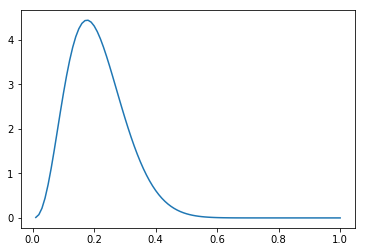

In [48]:
from scipy import stats
x=np.linspace(0,1,101)[1:]
plt.plot(x,stats.beta.pdf(x,4,15,0,1))
temp={'yLT':stats.beta.rvs(4,15,0,1,size=100),'N':100}
fit=smBeta.sampling(data=temp,chains=6,n_jobs=6,
        seed=1,thin=4,iter=55000,warmup=5000)
print(fit)
w=fit.extract()
a=np.exp(w['a'])
b=np.exp(w['b'])

0.45243136720737848

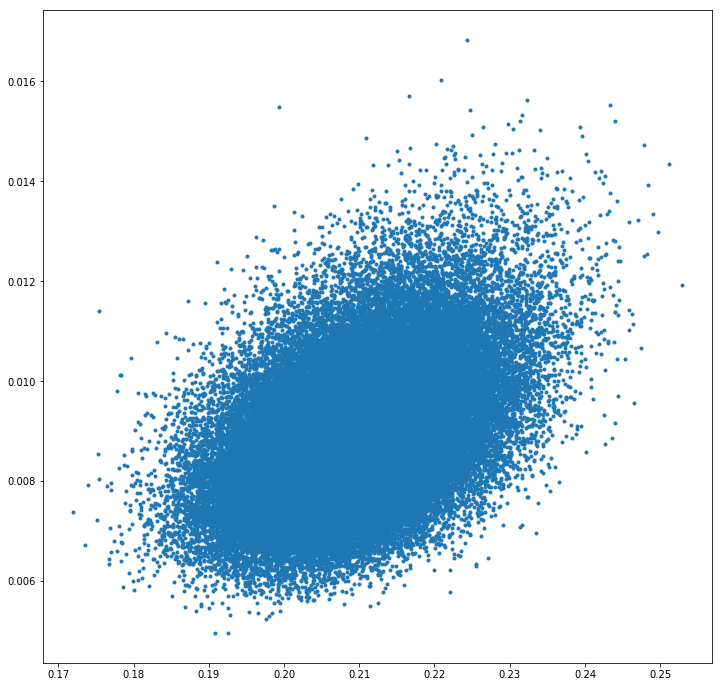

In [54]:
from scipy.special import gamma, digamma,polygamma,beta
plt.figure(figsize=(12,12))
gA=digamma(a)-digamma(a+b)
gB=digamma(b)-digamma(a+b)
tA=polygamma(1,a)-polygamma(1,a+b)

var=a*b/np.square(a+b)/(a+b+1)
ex=a/(a+b)
q1=ex
q2=var

#q2=g
#k=np.exp(a)
#l=np.exp(b)
#q1=np.log(np.square(k)*digamma(2)+digamma(1))/(2*digamma(2))-g/(polygamma(1,1)+1)


plt.plot(q1,q2,'.')
#plt.ylim([0,1])
#plt.xlim([0,1])
np.corrcoef(q1,q2)[0,1]

## Wald distribution Fisher information

$$f(x)=\frac{\alpha}{\sigma \sqrt{2 \pi x^3}}\exp\left(-\frac{(\nu x-\alpha)^2}{2 \sigma^2 x}\right)$$

$E[X]=\alpha/\nu$

$E[1/X]=\nu/\alpha +\sigma^2/\alpha^2$

$$I_{\alpha \sigma \nu} = \begin{pmatrix} \frac{2}{\alpha^2}+\frac{\nu}{\sigma^2 \alpha} & \frac{2}{\sigma \alpha} & \frac{1}{\sigma}\\
. & \frac{1}{\sigma^2} &0\\
. & . & \frac{\alpha}{\sigma^2 \nu}\end{pmatrix} $$

In [ ]:
()k